In [1]:
import numpy as np                                                                                            
import pandas as pd                                                                                           
import argparse                                                                                               
import matplotlib.pyplot as plt                                                                               
from sklearn.externals import joblib                                                                          
import sys                                                                                                    
sys.path.insert(0, '../')                                                                                     
import reco.reco_dl1_to_dl2 as reco_dl1_to_dl2                                                                
import reco.plot_dl2 as plot_dl2                                                                              
import reco.utils as utils

In [2]:
#We must have two files, one with dl1 gamma events and other with dl1 proton events
PATH_EVENTS = "/scratch/bernardos/LST1/Events/"
gammafile = PATH_EVENTS+"gamma_events_point.h5"
protonfile = PATH_EVENTS+"proton_events.h5"
print(gammafile,protonfile)

/scratch/bernardos/LST1/Events/gamma_events_point.h5 /scratch/bernardos/LST1/Events/proton_events.h5


In [6]:
#Read the files into pandas dataframes:
df_gammas = pd.read_hdf(gammafile,                                                                   
                        key="gamma_events")                                                               
df_proton = pd.read_hdf(protonfile,                                                                  
                        key="proton_events")
df_gammas = df_gammas.dropna() #Drop bad values of width                                                    
df_proton = df_proton.dropna()

df_gammas.keys()

Index(['obs_id', 'event_id', 'mc_energy', 'mc_alt', 'mc_az', 'mc_core_x',
       'mc_core_y', 'mc_h_first_int', 'mc_type', 'gps_time', 'width', 'length',
       'wl', 'phi', 'psi', 'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis',
       'mc_alt_tel', 'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient',
       'intercept', 'src_x', 'src_y', 'disp', 'hadroness'],
      dtype='object')

In [7]:
#From all the keys, choose the features to train the random forest.
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi']

In [8]:
#Split the dataframes in train and test sets:
train,test = reco_dl1_to_dl2.split_traintest(df_gammas,0.5)
test = test.append(df_proton,ignore_index=True) #Protons are only for testing when trainin Energy/Direction reco.

/afs/ciemat.es/user/b/bernardos/.conda/envs/ctapipe/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
#Train Energy and Direction (Disp method) reconstruction:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi']
Number of events for training:  267382
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp Reconstruction...
Random Forest trained!
Done!


In [11]:
#Predict energy and direction for the test set:
test['e_rec'] = RFreg_Energy.predict(test[features])                                                      
test['disp_rec'] = RFreg_Disp.predict(test[features])                                                     
                                                                                                              
test['src_x_rec'],test['src_y_rec'] = utils.disp_to_pos(test['disp_rec'],                                 
                                                       test['x'],                                              
                                                       test['y'],                                              
                                                       test['psi'])
test.keys()

Index(['disp', 'event_id', 'gps_time', 'hadroness', 'impact', 'intensity',
       'intercept', 'is_train', 'kurtosis', 'length', 'mc_alt', 'mc_alt_tel',
       'mc_az', 'mc_az_tel', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'obs_id', 'phi', 'psi', 'r',
       'skewness', 'src_x', 'src_y', 'time_gradient', 'width', 'wl', 'x', 'y',
       'e_rec', 'disp_rec', 'src_x_rec', 'src_y_rec'],
      dtype='object')

In [12]:
#For the Gamma/Hadron classifier we wll use these reconstructed energy and direction to train:
features_sep = list(features)                                                                             
features_sep.append('e_rec')                                                                              
features_sep.append('disp_rec')

In [13]:
#We split again the previous test set into two new train/test sets with reconstructed energy and direction
train,test = reco_dl1_to_dl2.split_traintest(test,0.75)

In [14]:
#Now we can train the Random Forest Classifier
RFcls_GH = reco_dl1_to_dl2.trainRFsep(train,features_sep)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'e_rec', 'disp_rec']
Number of events for training:  363887
Training Random Forest Classifier for Gamma/Hadron separation...
Random Forest trained!
Done!


In [15]:
#The reconstructed hadroness is 0 if classified as gamma, 1 if classified as proton
test['hadro_rec'] = RFcls_GH.predict(test[features_sep])

In [16]:
#We can store the trained RF for later use, to reconstruc any event
fileE = "RFreg_Energy.sav"                                                           
fileD = "RFreg_Disp.sav"                                                             
fileH = "RFcls_GH.sav"                                                               
joblib.dump(RFreg_Energy, fileE)                                                                      
joblib.dump(RFreg_Disp, fileD)                                                                        
joblib.dump(RFcls_GH, fileH)

['RFcls_GH.sav']

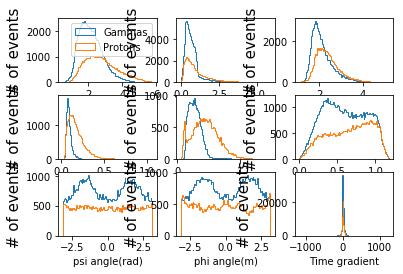

In [17]:
#Now we can plot some results to check the performance of the Random Forests:
plot_dl2.plot_features(test)

0.03716732225729078 0.6619896346016249


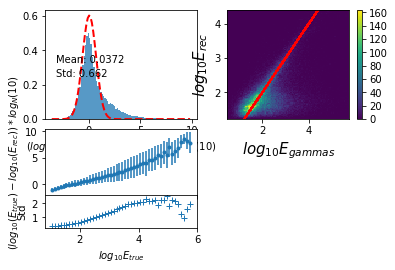

In [18]:
plot_dl2.plot_e(test)

0.06314379865256231 0.23873977101632957


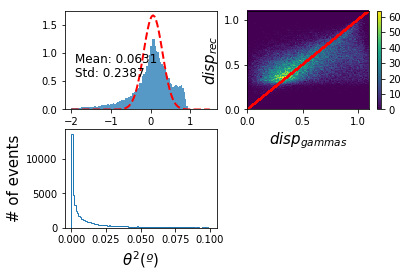

In [19]:
plot_dl2.plot_disp(test)

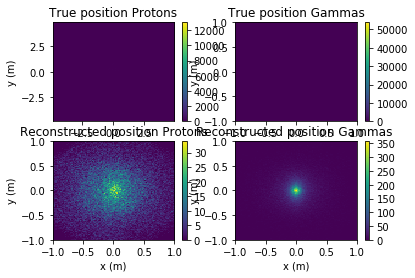

In [20]:
plot_dl2.plot_pos(test)

Feature importances (gini index)
1. width (0.201052)
2. length (0.159091)
3. disp_rec (0.141147)
4. intensity (0.106014)
5. time_gradient (0.085940)
6. e_rec (0.084747)
7. wl (0.081099)
8. phi (0.080938)
9. psi (0.059973)


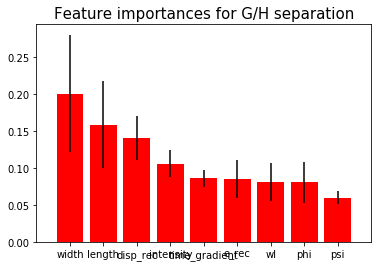

In [21]:
plot_dl2.plot_importances(RFcls_GH,features_sep)

0.7216032352868943


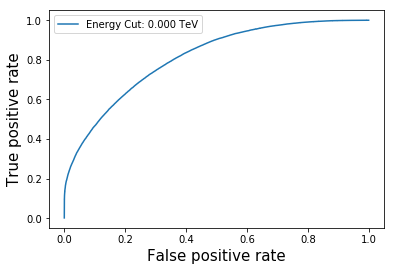

In [22]:
plot_dl2.plot_roc(RFcls_GH,test,features_sep,-1)

In [23]:
#Mono analysis in LST1 is very limited at low energies, we can do cuts in e_rec to improve the performance:

cut = 500. #Select a cut in MeV

e_cut = np.log10(cut) 
test_cut = test[test['e_rec']>e_cut]

0.04678210487977214 0.544152254136712


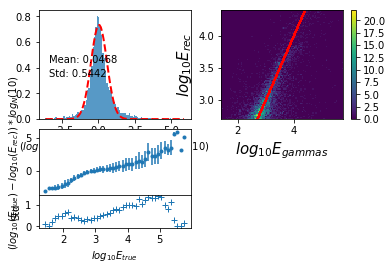

In [24]:
plot_dl2.plot_e(test_cut)

0.012851589591782404 0.14312383142711158


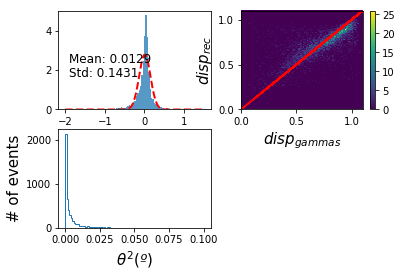

In [25]:
plot_dl2.plot_disp(test_cut)

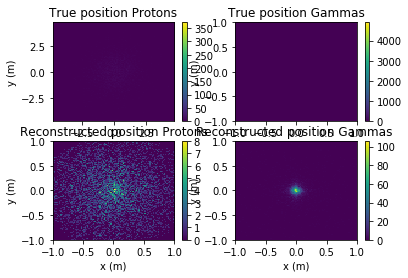

In [26]:
plot_dl2.plot_pos(test_cut)

0.9294936284372904


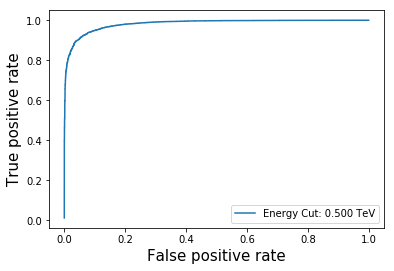

In [27]:
plot_dl2.plot_roc(RFcls_GH,test_cut,features_sep,e_cut)